In [32]:
#https://www.kaggle.com/datasets/504743cb487a5aed565ce14238c6343b7d650ffd28c071f03f2fd9b25819e6c9?resource=download-directory

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(3,64,64)):
    image_tensor = (image_tensor + 1) / 2 #convert image to 0 1 because image passed as -1 to 1
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

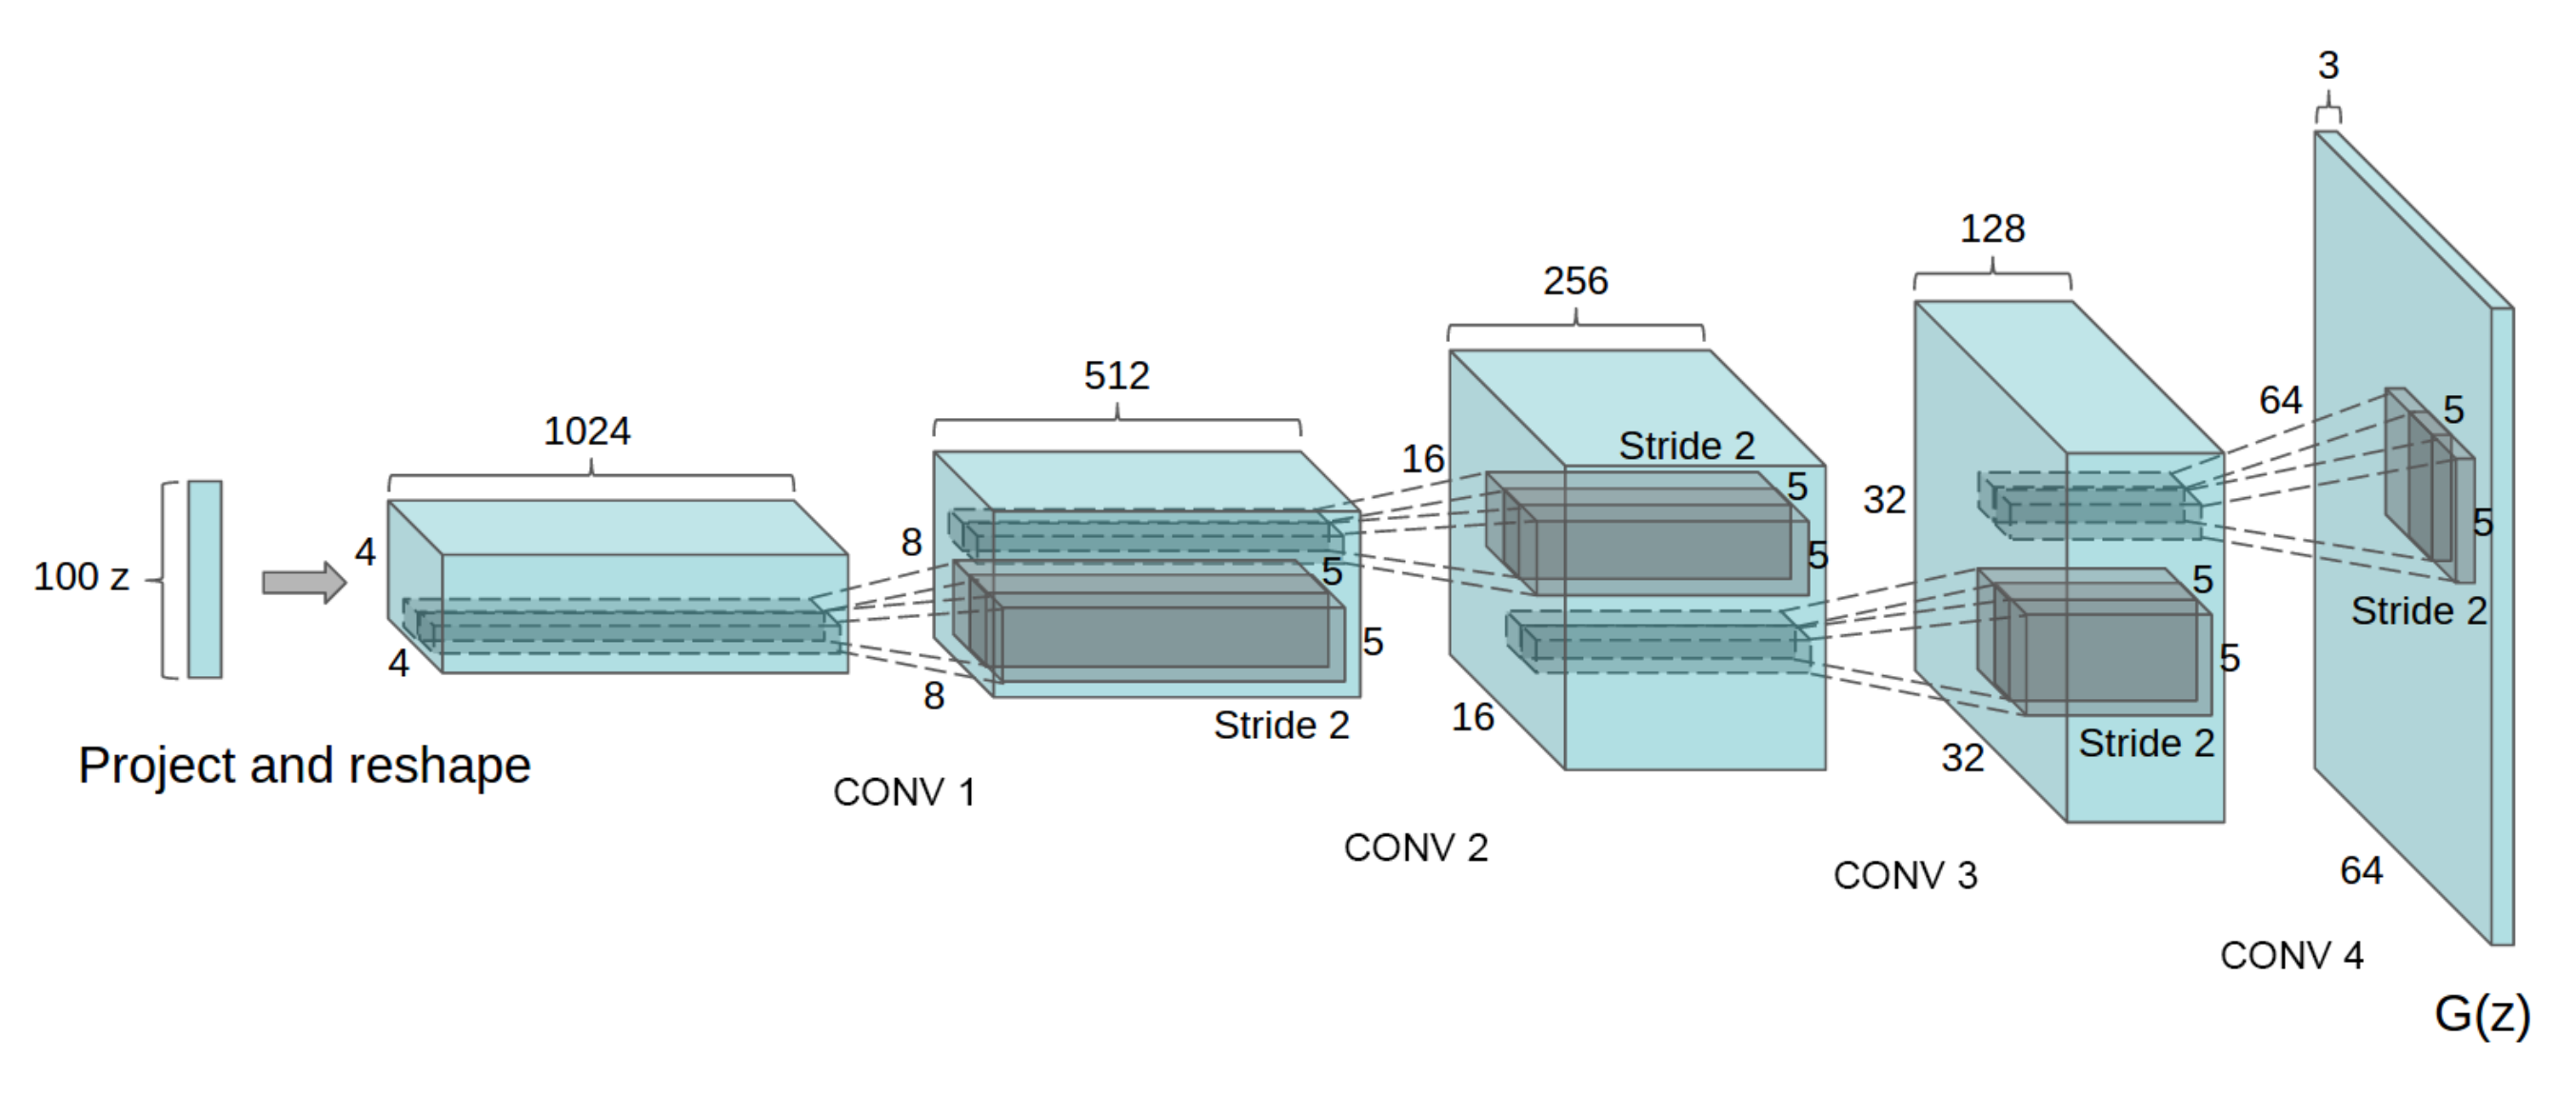

# Generator

In [3]:
class Generator(nn.Module):
    
    def __init__(self,z_dim,im_channels,hidden_dim):
        super(Generator,self).__init__()
        #image will be 128,100,1,1 noise should be 100x1x1 (don't worry just pass the noise and forward will make it 100x1x1)
        self.z_dim = z_dim
        self.gen = nn.Sequential(
        self.make_gen_block(z_dim , hidden_dim*16,kernel_size=4, stride=1,padding=0),  #1x1 will be 128*1024*4*4
        self.make_gen_block(hidden_dim*16 , hidden_dim*8),                        #512
        self.make_gen_block(hidden_dim*8 , hidden_dim*4),                      #256
        self.make_gen_block(hidden_dim*4 , hidden_dim*2),                       #128
        self.make_gen_block(hidden_dim*2 , im_channels,final_layer=True)    #3*64*64
        ) 
    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding=1, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride,padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding=padding),
                nn.Tanh()
                
            )

    def forward(self,noise):
        #want to insert 100 and convert it to (100,1,1) len(noise) so if you change the length later
        noise=noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)   

# Create Noise Vector

In [4]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

In [5]:
gen = Generator(100,3,64)
num_test = 128
test_hidden_block = gen.make_gen_block(100,16*64, kernel_size=4, stride=2,padding=0)
test_uns_noise = torch.rand((128,100,1,1))
hidden_output = test_hidden_block(test_uns_noise)
hidden_output.shape
#o=(n-1)*s+m
#m is kernalsize and s is strid
#7
#strid 4 and kernal 2 and padding 1 will do upsampling also better since you will save edges information while upsampling
#kernal_size=2 and strid 2 will double each time so you don't have to calculate each block what the kernel_size and strid

torch.Size([128, 1024, 4, 4])

# Discriminator

In [6]:
class Discriminator(nn.Module):
    
    #Reverse of generator start big and goes to 1 output 
    #64*2 64*4 ... to reach channels 1024 and downsample 64 of width and heigh to 1 
   
    def __init__(self, im_chan, hidden_dim): #hidden_dim will be 64
        
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4),
            self.make_disc_block(hidden_dim*4, hidden_dim * 8),
            self.make_disc_block(hidden_dim * 8, 1,padding=0, final_layer=True),
            )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding=1, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride,padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.Conv2d(input_channels, output_channels, kernel_size, stride,padding=padding),
                nn.Tanh()
                
            )

    def forward(self,x):
        disc_pred = self.disc(x)
        return disc_pred.view(len(disc_pred),-1) #x is the image
        

# Test

In [8]:
# disc = Discriminator(3,64)
# num_test = 128
# test_hidden_block = disc.disc_block(3,64, kernel_size=4, stride=2,padding=1)#3*64*64
# test_uns_noise = torch.rand((128,3,64,64))
# hidden_output = test_hidden_block(test_uns_noise)
# print(hidden_output.shape)

# #Block2
# test_hidden_block = disc.disc_block(64,64*2, kernel_size=4, stride=2,padding=1)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)

# #block3
# test_hidden_block = disc.disc_block(64*2,64*4, kernel_size=4, stride=2,padding=1)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)
# #block4
# test_hidden_block = disc.disc_block(64*4,64*8, kernel_size=4, stride=2,padding=1)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)
# #block5
# test_hidden_block = disc.disc_block(64*8,1, kernel_size=4, stride=2,padding=0)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)

In [9]:
#hidden_output.reshape(len(hidden_output),-1).shape # To see the output of 128 image as 128,1 true of false

torch.Size([128, 16384])

# Weight Initializer

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [8]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    print(disc(x).shape)
    assert disc(x).shape == (N,1), "Discriminator test failed" 
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Sucess")

In [9]:
test()

torch.Size([8, 1])
Sucess


# Traning
Now you can put it all together! Remember that these are your parameters:

criterion: the loss function          
n_epochs: the number of times you iterate through the entire dataset when training               
z_dim: the dimension of the noise vector              
display_step: how often to display/visualize the images           
batch_size: the number of images per forward/backward pass           
lr: the learning rate          
beta_1, beta_2: the momentum term          
device: the device type           

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3 #we have to change it when we m
Z_DIM = 100
NUM_EPOCHS = 3
HIDDEN_DIM = 64
HIDDEN_DIM_DISC = 64
DISPLAY_STEP = 500
beta_1 = 0.5 
beta_2 = 0.999

In [11]:
transform=transforms.Compose(
    [ 
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)])
]
)

In [13]:
#dataset=MNIST(root="dataset/",train=True,transform=transform,download=False)
dataset=datasets.ImageFolder(root="D:\celeb_dataset",transform=transform)
dataloader = DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)
feature,labels=next(iter(dataloader))
print(feature.shape)

torch.Size([128, 3, 64, 64])


## Visualizing the data 

torch.float32


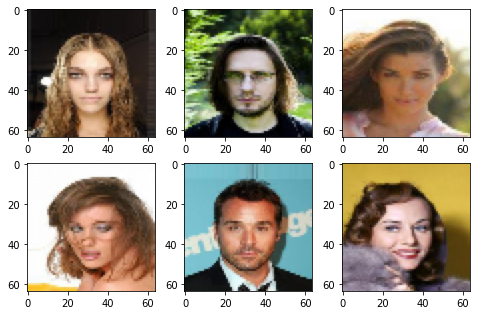

In [51]:
import numpy as np
plt.figure(figsize=(8,8))
for i in range(6):
    plt.subplot(3,3,i+1)
    image=(feature[i]+1)/2
    image=np.transpose(image,(1, 2, 0))
    plt.imshow(image)
    
print(feature[0].dtype)

In [26]:
gen = Generator(Z_DIM,CHANNELS_IMG,HIDDEN_DIM).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta_1, beta_2))
disc = Discriminator(CHANNELS_IMG,HIDDEN_DIM_DISC).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(beta_1, beta_2))
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [27]:
criterion = nn.BCEWithLogitsLoss()

Epoch 0, step 500: Generator loss: 1.1222076290249836, discriminator loss: 0.5066545491814618


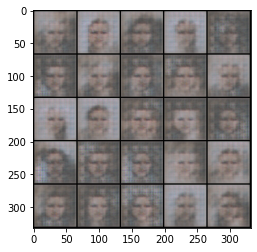

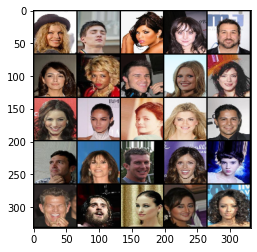

Epoch 0, step 1000: Generator loss: 1.0359035516977326, discriminator loss: 0.5293041869401934


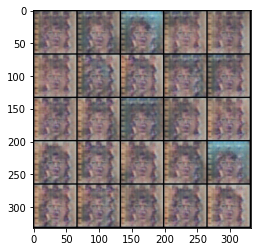

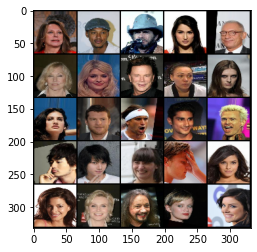

Epoch 0, step 1500: Generator loss: 0.994198970198633, discriminator loss: 0.6941971837282177


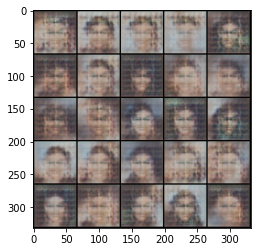

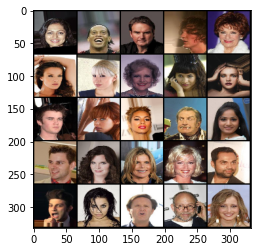

Epoch 1, step 2000: Generator loss: 1.3132605965137478, discriminator loss: 0.8132595424652105


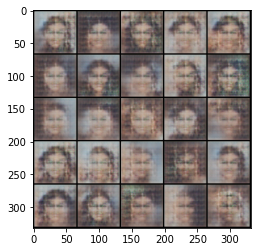

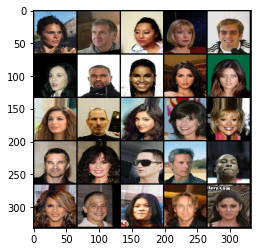

Epoch 1, step 2500: Generator loss: 1.3132603492736805, discriminator loss: 0.8132589474916472


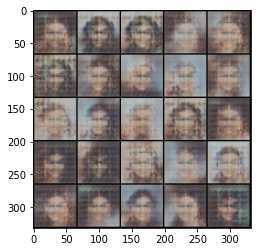

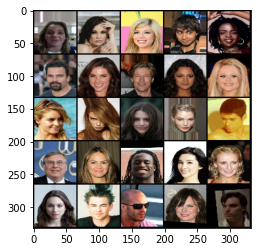

Epoch 1, step 3000: Generator loss: 1.3132598235607125, discriminator loss: 0.8132579591274257


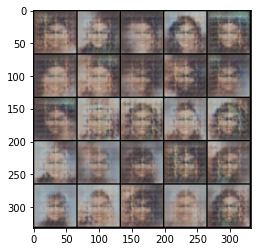

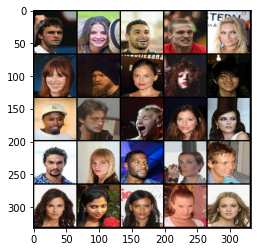

Epoch 2, step 3500: Generator loss: 1.2317296204566952, discriminator loss: 0.8131297222375875


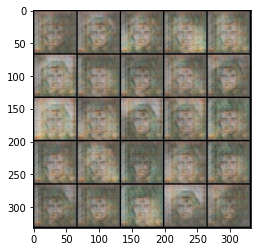

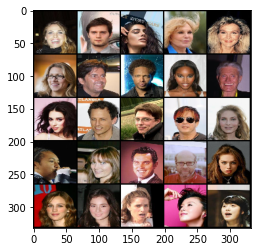

Epoch 2, step 4000: Generator loss: 0.9174942195415497, discriminator loss: 0.5368440011739732


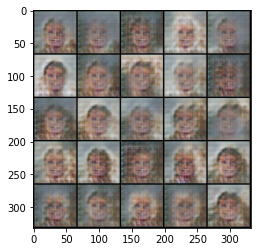

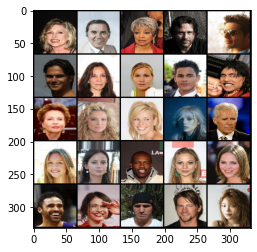

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(NUM_EPOCHS):
    for real,_ in dataloader:
        cur_batch_size = len(real) #redundant
        real=real.to(device)
        
        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise=get_noise(cur_batch_size,Z_DIM,device=device) #don't forget passing device
        #Generate the images from this noise
        fake=gen(fake_noise)
        #Run discriminaotr on both real and fake 
        disc_fake_pred=disc(fake.detach())
        disc_fake_loss=criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        
        disc_real_pred=disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / DISPLAY_STEP
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()
        
        
        #Update The Generator
        gen_opt.zero_grad()
        fake_noise_2=get_noise(cur_batch_size,Z_DIM,device=device)
        fake_2=gen(fake_noise_2)
        #get the output from discrminator
        disc_fake_pred=disc(fake_2)
        gen_loss=criterion(disc_fake_pred,torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / DISPLAY_STEP
        
        ## Visualization code ##
        if cur_step % DISPLAY_STEP == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1 #how many batches in the 1 epoch   increase with each batch (every 500 batch display)


# Test another code

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1 #we have to change it when we m
Z_DIM = 100
NUM_EPOCHS = 10
HIDDEN_DIM = 64
HIDDEN_DIM_DISC = 64
DISPLAY_STEP = 500
beta_1 = 0.5 
beta_2 = 0.999

In [42]:


class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

Epoch 0, step 5000: Generator loss: 0.11841372543573381, discriminator loss: 0.3074126609563827


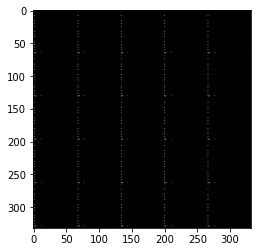

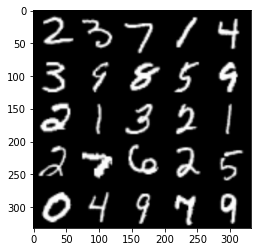

Epoch 1, step 5500: Generator loss: 0, discriminator loss: 0


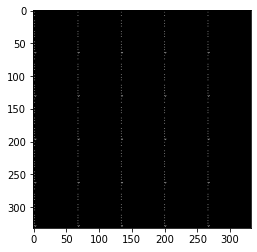

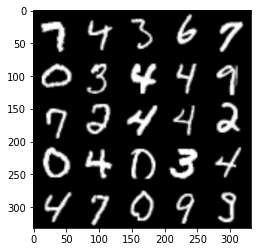

In [ ]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1
dataset = MNIST(root="dataset/", train=True, transform=transforms,
                       download=True)

# comment mnist above and uncomment below if train on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        ## Visualization code ##
        if cur_step % DISPLAY_STEP == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1 #how many batches in the 1 epoch   increase with each batch (every 500 batch display)